In [8]:
import os, sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from keras.models import Sequential
from keras.layers import TimeDistributed, LSTM, Dense, RepeatVector
from numpy import array, array_equal, argmax
import tensorflow as tf
import attention_decoder

"""
Sample keras model
"""
def create_model_1():
    Note = Input(shape=(sequence_length, n_vocab), dtype = 'float32')
    y = LSTM(400, input_shape = (sequence_length, n_vocab), return_sequences = True ) (Note)
    y = Dropout(0.4) (y)
    y = LSTM(400) (y)
    y = Dropout(0.4) (y)
    # Two weights, two bias
    # If coordinates of input is (X1, X2), and this layer is (Y1, Y2, Y3, Y4)
    # Result would be 
    y1 = Lambda(lambda x: x*2)( Dense(2, activation = 'tanh') (y) )
    y2 = Dense(2, activation = 'linear') (y)
    Coordinates = Input(shape= (2, ), dtype = 'float32')
    print (keras.backend.shape(y1))
    print (keras.backend.shape(Coordinates))
    c1 = Multiply()([y1, Coordinates])
    c = Add()([y2, c1])
    m = Model(inputs = [Note, Coordinates], outputs = c)

    print (m.summary())
    m.compile(loss='mean_squared_error', optimizer='adam')

    return m

def create_sample_attention_model () :
    model = Sequential()
    model.add(LSTM(150, input_shape=(n_timesteps_in, n_features), return_sequences=True))
    model.add(attention_decoder.AttentionDecoder(150, n_features))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

Using TensorFlow backend.


ImportError: No module named 'attention_decoder'

Seems like for this problem, I need to use Tensorflow

In [2]:
output_ta = tf.TensorArray(size=784, dtype=tf.float32)  # store trained/sampled pixel
def loop_fn(time, cell_output, cell_state, loop_state):
    emit_output = cell_output  # == None for time == 0
    if cell_output is None:
        # time=0, everything here will be used for initialization only
        next_cell_state = cell_init_state
        next_pixel = cell_init_pixel
        next_loop_state = output_ta
    else:  
        # pass the last state to the next
        next_cell_state = cell_state
        next_pixel = tf.cond(is_training,
                         lambda: inputs_ta.read(time - 1),
                         lambda: tf.contrib.distributions.Bernoulli(
                             probs=tf.nn.sigmoid(tf.layers.dense(cell_output, 1, 
                                 name='output_to_p', activation=tf.nn.sigmoid,
                                 reuse=True)),
                             dtype=tf.float32).sample())
        next_loop_state = loop_state.write(time - 1, next_pixel)
    elements_finished = (time >= 784)
    return (elements_finished, next_pixel, next_cell_state,
            emit_output, next_loop_state)

In [6]:
from tensorflow.python.ops.rnn import _transpose_batch_time

def sampling_rnn(self, cell, initial_state, input_, seq_lengths):

    # raw_rnn expects time major inputs as TensorArrays
    max_time = ...  # this is the max time step per batch
    inputs_ta = tf.TensorArray(dtype=tf.float32, size=max_time, clear_after_read=False)
    inputs_ta = inputs_ta.unstack(_transpose_batch_time(input_))  # model_input is the input placeholder
    input_dim = input_.get_shape()[-1].value  # the dimensionality of the input to each time step
    output_dim = ...  # the dimensionality of the model's output at each time step
    
    def loop_fn(time, cell_output, cell_state, loop_state):
        """
        Loop function that allows to control input to the rnn cell and manipulate cell outputs.
        :param time: current time step
        :param cell_output: output from previous time step or None if time == 0
        :param cell_state: cell state from previous time step
        :param loop_state: custom loop state to share information between different iterations of this loop fn
        :return: tuple consisting of
          elements_finished: tensor of size [bach_size] which is True for sequences that have reached their end,
            needed because of variable sequence size
          next_input: input to next time step
          next_cell_state: cell state forwarded to next time step
          emit_output: The first return argument of raw_rnn. This is not necessarily the output of the RNN cell,
            but could e.g. be the output of a dense layer attached to the rnn layer.
          next_loop_state: loop state forwarded to the next time step
        """
        if cell_output is None:
            # time == 0, used for initialization before first call to cell
            next_cell_state = initial_state
            # the emit_output in this case tells TF how future emits look
            emit_output = tf.zeros([output_dim])
        else:
            # t > 0, called right after call to cell, i.e. cell_output is the output from time t-1.
            # here you can do whatever ou want with cell_output before assigning it to emit_output.
            # In this case, we don't do anything
            next_cell_state = cell_state
            emit_output = cell_output  

        # check which elements are finished
        elements_finished = (time >= seq_lengths)
        finished = tf.reduce_all(elements_finished)

        # assemble cell input for upcoming time step
        current_output = emit_output if cell_output is not None else None
        input_original = inputs_ta.read(time)  # tensor of shape (None, input_dim)

        if current_output is None:
            # this is the initial step, i.e. there is no output from a previous time step, what we feed here
            # can highly depend on the data. In this case we just assign the actual input in the first time step.
            next_in = input_original
        else:
            # time > 0, so just use previous output as next input
            # here you could do fancier things, whatever you want to do before passing the data into the rnn cell
            # if here you were to pass input_original than you would get the normal behaviour of dynamic_rnn
            next_in = current_output

        next_input = tf.cond(finished,
                             lambda: tf.zeros([self.batch_size, input_dim], dtype=tf.float32),  # copy through zeros
                             lambda: next_in)  # if not finished, feed the previous output as next input

        # set shape manually, otherwise it is not defined for the last dimensions
        next_input.set_shape([None, input_dim])

        # loop state not used in this example
        next_loop_state = None
        return (elements_finished, next_input, next_cell_state, emit_output, next_loop_state)

    outputs_ta, last_state, _ = tf.nn.raw_rnn(cell, loop_fn)
    outputs = _transpose_batch_time(outputs_ta.stack())
    final_state = last_state

    return outputs, final_state

In [9]:
import cv2
import os
import pylab as pl
%matplotlib inline

### Image size 

(288, 432, 3)

In [10]:
cap = cv2.VideoCapture(os.path.join('..', 'target', '0', '0.mp4'))

In [16]:
def crop_and_resize (frame):
    
    # cv2.resize(frame, (10, 10), interpolation = cv2.INTER_AREA)
#     return frame[36:250, 114:328, :]
    return cv2.resize(frame[36:250, 114:328, :], (15, 15), interpolation = cv2.INTER_LINEAR)

In [156]:
data = []

counter = 0
while (cap.isOpened()):
    ret, frame = cap.read()

    if not ret:
        break
        
    data.append(crop_and_resize(frame))
    
    counter += 1

In [157]:
pl.imshow(data[18])

IndexError: list index out of range

### Get instruction signal

Parse the video file into instruction sequence

In [11]:
instruction_dict = {'up': 0, 'right': 1, 'down': 2, 'left': 3}

In [12]:
reverse_instruction_dict = dict((v,k) for (k,v) in instruction_dict.items())

In [36]:
def decode ( sequence ):
    return ' '.join([reverse_instruction_dict[s] for s in sequence])

In [37]:
def get_instruction_btw_frame( prev_frame, cur_frame ):
    diff = abs(prev_frame.astype(np.int32) - cur_frame.astype(np.int32))
    vals = np.argwhere(diff >= 20)
    
    points = set()
    for val in vals:
        points.add(tuple(val[:2]))
    
    # if prev_frame[points[0]] ~ (255,255,255), points[0] is target, points[1] is start
    # otherwise reverse
    
    points = list(points)
    
    if np.sum(abs(prev_frame[points[0]].astype(np.int32) - np.array([255, 255, 255]))) > 20:
        source = np.array(points[0])
        target = np.array(points[1])
    else:
        source = np.array(points[1])
        target = np.array(points[0])

        
    if np.array_equal(target - source , [0, 1]):
        return 1
    if np.array_equal(target - source , [0, -1]):
        return 3
    if np.array_equal(target - source , [1, 0]):
        return 2
    if np.array_equal(target - source , [-1, 0]):
        return 0
        

def get_instructions ( video_path, debug = True ):
    cap = cv2.VideoCapture(video_path)
    
    prev_frame = None
    instructions = []

    counter = 0
    while (cap.isOpened()):
        ret, frame = cap.read()

        if not ret:
            break
            
        c_frame = crop_and_resize(frame)
        
        # Get the instruction between prev_frame and frame
        if prev_frame is not None:
            instruction = get_instruction_btw_frame (prev_frame, c_frame)
            instructions.append(instruction)

        counter += 1

        prev_frame = c_frame
        
    #pl.imshow(prev_frame)
    
    if debug :
        print ('There are %d frames ' % counter)
        print ('The list of instructions are %s ' % decode( instructions ))
    
    return decode( instructions )

In [18]:
get_instructions(os.path.join('..', 'target', '0', '0.mp4'))

There are 19 frames 
The list of instructions are down,down,down,down,down,down,left,left,down,down,left,left,left,left,left,left,down,left 


[2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3]

### Baseline model

LSTM model with attention with the image being additional input to encoded vector.

The simplest model would have image flattened out into an 100-cell vectors. Colors are coded.

### Generate instructions and commands text files and vocab files

In [19]:
src_file = 'instructions.txt'
tgt_file = 'commands.txt'
src_vocab_file = 'instructions.vocab'
tgt_vocab_file = 'commands.vocab'

In [ ]:
"""
Sample text
Alexander Reese,100,move the purple block between the yellow block and elastic red block stop in the creak of the purple L-shape block
"""

In [29]:
from collections import defaultdict

puzzle_to_instructions = defaultdict(list)

with open(os.path.join('..', 'annotation.csv'), 'r') as fh:
    for line in fh:
        parts = line.split(',')
        
        puzzle = int(parts[1])
        text = ' '.join( parts[2:] )
        
        text = text.replace ('-', ' ').strip()
        
        if text != '':
            puzzle_to_instructions[puzzle].append(text)
            


In [35]:
import pickle

with open('puzzle.dat', 'wb') as fh:
    pickle.dump(puzzle_to_instructions, fh)

In [53]:
with open(os.path.join('..', 'data', src_file), 'w') as fh:
    with open(os.path.join('..', 'data', tgt_file), 'w') as fh2:
        
        for puzzle in range(200):
            instructions = puzzle_to_instructions[puzzle]
            
            directory = puzzle // 100
            
            commands = get_instructions(os.path.join('..', 'target', str(directory), str(puzzle) + '.mp4'), debug = False)
            
            for instruction in instructions[:-1]:
                fh.write(instruction.lower())
                fh.write('\n')
                fh2.write(commands)
                fh2.write('\n')

### Create vocabulary files

In [43]:
import tflearn

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [44]:
from tflearn.data_utils import VocabularyProcessor

In [52]:
vp = VocabularyProcessor(min_frequency=10, max_document_length = 100)

vp.fit(t for t in puzzle_to_instructions[puzzle] for puzzle in range(200)) 

t = vp.vocabulary_

with open(os.path.join('..', 'data', src_vocab_file), 'w') as fh:
    for word in t._reverse_mapping:
        fh.write(word)
        fh.write('\n')

### Create eval files

In [54]:
eval_src_file = 'eval_instructions.txt'
eval_tgt_file = 'eval_commands.txt'

with open(os.path.join('..', 'data', eval_src_file), 'w') as fh:
    with open(os.path.join('..', 'data', eval_tgt_file), 'w') as fh2:
        
        for puzzle in range(200):
            instructions = puzzle_to_instructions[puzzle]
            
            directory = puzzle // 100
            
            commands = get_instructions(os.path.join('..', 'target', str(directory), str(puzzle) + '.mp4'), debug = False)
            
            instruction = instructions[-1]
            fh.write(instruction.lower())
            fh.write('\n')
            fh2.write(commands)
            fh2.write('\n')

### Result from one run with

```
num_units=128,
optimizer="sgd",
learning_rate=0.2,
num_train_steps=2000,
```

In [55]:
train_ppls = [(50, 3.622860993755861), (100, 2.861048874787788), (150, 2.7144358871103695), (200, 2.6244221451141554), (250, 2.559963936057708), (300, 2.4906299530576717), (350, 2.4611581223296883), (400, 2.4081972736561292), (450, 2.376238414347918), (500, 2.3149748093621305), (550, 2.2807155686298373), (600, 2.2271950330723733), (650, 2.1852261228233196), (700, 2.133554434277888), (750, 2.0864403448274174), (800, 2.0275573143614056), (850, 1.966460910555963), (900, 1.9100762230672461), (950, 1.8597766285396615), (1000, 1.8106065211986038), (1050, 1.7577774811347908), (1100, 1.7159142948821353), (1150, 1.6667710320040563), (1200, 1.6176787509841954), (1250, 1.461931473293547), (1300, 1.4199632900484251), (1350, 1.395266490093124), (1400, 1.3680164569824662), (1450, 1.3074188319379587), (1500, 1.289243310363728), (1550, 1.2762814642136484), (1600, 1.2600097457796327), (1650, 1.242998112668705), (1700, 1.2327585428902734), (1750, 1.222338292542516), (1800, 1.2157578290950826), (1850, 1.2029619735575519), (1900, 1.1996501731730116), (1950, 1.1976915749849835), (2000, 1.196468185521777)]
dev_ppls = [(200, 2.57433564083528), (400, 2.456461232812054), (600, 2.2005683089711163), (800, 2.0124692521350296), (1000, 1.814219438942708), (1200, 1.723100523239358), (1400, 1.6296202548584209), (1600, 1.6325943888569625), (1800, 1.6608891188844597), (2000, 1.673063526619738)]

In [56]:
%matplotlib inline

In [57]:
import matplotlib.pyplot as plt 

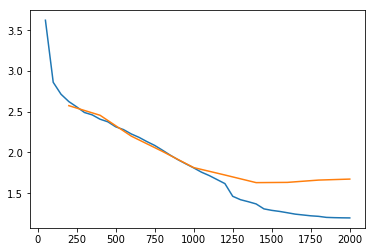

In [58]:
plt.plot([t[0] for t in train_ppls], [t[1] for t in train_ppls])
plt.plot([t[0] for t in dev_ppls], [t[1] for t in dev_ppls])